## **An Introduction to kinetic MonteCarlo models**



### **Basic kinetic MonteCarlo model (step by step)**

**Step 1: Define the System and States**
A KMC simulation tracks a system as it transitions between discrete states over time. In this introductory example, let’s use a simple adsorption-desorption process:

**States:** A surface with one adsorption site that can either be occupied by a molecule (state 1) or vacant (state 0).

**Event** Two events can occur:
* **Adsorption**: A molecule binds to the site if it is vacant.

* **Desorption**: The molecule leaves the site if it is occupied.

**Step 2: Define Transition Rates**
KMC relies on transition rates to determine how likely an event is to occur. These rates are often based on physical or experimental data but can be simplified for this example:

* **Adsorption Rate** ($k_{ads}$): Rate at which molecules arrive and bind to the surface.

* **Desorption Rate** ($k_{des}$): Rate at which a bound molecule leaves the surface.

**Step 3: Simulate Events Using the KMC Algorithm**

In KMC, we simulate the evolution of the system by probabilistically selecting and executing events, and advancing time accordingly.

**Calculate Propensities**: For each possible event, compute the propensity (or likelihood) of the event occurring based on its rate and the current state. For example:

- If the site is vacant:  
  $ \text{propensity}_{\text{ads}} = k_{\text{ads}}. $

- If the site is occupied:  
  $ \text{propensity}_{\text{des}} = k_{\text{des}}. $

**Select the Next Event**: Draw a random number to determine which event will occur next. The probability of selecting an event is proportional to its propensity.

**Advance Time**: Update the simulation time using a random exponential variable, which represents the time until the next event.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define rates (in events per second)
k_ads = 1.0  # adsorption rate
k_des = 0.05  # desorption rate

# Initial state: site is vacant (0)
state = 0
time = 0.0
end_time = 100  # run simulation for 10 seconds

# Store times and states for analysis
times = [time]
states = [state]


##
while time < end_time:
    if state == 0:  # Site is vacant
        prop_ads = k_ads
        prop_des = 0.0
    else:  # Site is occupied
        prop_ads = 0.0
        prop_des = k_des

    # Total propensity
    total_propensity = prop_ads + prop_des
    if total_propensity == 0:
        break  # No more events possible

    # Time until next event
    delta_t = -np.log(np.random.rand()) / total_propensity
    time += delta_t

    # Choose event
    if np.random.rand() < prop_ads / total_propensity:
        state = 1  # Adsorb molecule
    else:
        state = 0  # Desorb molecule

    # Store time and state
    times.append(time)
    states.append(state)

# Display the results
for t, s in zip(times, states):
    print(f"Time: {t:.2f} s, State: {'Occupied' if s == 1 else 'Vacant'}")


Time: 0.00 s, State: Vacant
Time: 0.16 s, State: Occupied
Time: 40.60 s, State: Vacant
Time: 44.41 s, State: Occupied
Time: 66.30 s, State: Vacant
Time: 66.53 s, State: Occupied
Time: 88.61 s, State: Vacant
Time: 91.88 s, State: Occupied
Time: 114.76 s, State: Vacant


The algorithm only prints the event changes; the propensity or rate of transition is reflected in how long the system remains in the same state.


In kinetic Monte Carlo (KMC), when a site is occupied, the probability of adsorption (i.e., $ \text{prop}_{\text{ads}} $) is set to zero because no additional particle can adsorb onto an already occupied site. However, if you're considering the possibility of a particle remaining in place (not desorbing), this is inherently accounted for by the rate of desorption ($ \text{prop}_{\text{des}} $).


Steps to generate a kMC model:

1. Create a lattice and initialize it
2. Define the events (Diffusion, adsorption, desorption)
3. Initialize the transition rate constants for each type of process based on the activation energy values:
$$k_{ij} = \frac{k_B T }{h} \exp \left(-\frac{\Delta E_{ij}}{k_B T }\right)$$
4. Calculate the average escape time by event.

$$\Delta t_{escape} = - \frac{ln(\rho_2)}{k_{tot}}$$

5. Pick an event (BKL algorithm)
6. Apply event
7. Recalculate the transition rate constants
* Consider different transition energys (neighbours, interactions beetwen particles, PES, especial sites in the lattice)


## **First approach: Adsoption Percentage Curve**

In [3]:
L = 10
matrix = np.zeros((L, L))
matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lattice_size = 10  # 10x10 grid of adsorption sites
k_ads = 1.0        # adsorption rate
k_des = 0.05       # desorption rate
k_diff = 0.1       # diffusion rate (movement of adsorbed particles between sites)
end_time = 100     # simulation end time

# Initialize lattice (0 = vacant, 1 = occupied)
lattice = np.zeros((lattice_size, lattice_size))
time = 0.0
times = [time]
states = [lattice.copy()]


In [5]:
def calculate_propensities(lattice):
    # Calculate propensities for adsorption, desorption, and diffusion
    prop_ads = k_ads * np.sum(lattice == 0)       # Total adsorption propensity for vacant sites
    prop_des = k_des * np.sum(lattice == 1)       # Total desorption propensity for occupied sites
    prop_diff = k_diff * np.sum(lattice == 1)     # Total diffusion propensity for occupied sites
    return prop_ads, prop_des, prop_diff

def select_event(prop_ads, prop_des, prop_diff, total_propensity):
    # Select which event occurs
    r = np.random.rand() * total_propensity
    if r < prop_ads:
        return "adsorption"
    elif r < prop_ads + prop_des:
        return "desorption"
    else:
        return "diffusion"


In [6]:
while time < end_time:
    # Calculate propensities and total propensity
    prop_ads, prop_des, prop_diff = calculate_propensities(lattice)
    total_propensity = prop_ads + prop_des + prop_diff

    if total_propensity == 0:
        break  # No more events possible

    # Determine the time to the next event
    delta_t = -np.log(np.random.rand()) / total_propensity
    time += delta_t

    # Select the event type
    event_type = select_event(prop_ads, prop_des, prop_diff, total_propensity)

    # Execute the event
    vacant_sites = list(zip(*np.where(lattice == 0)))
    occupied_sites = list(zip(*np.where(lattice == 1)))

    if event_type == "adsorption" and vacant_sites:
        # Choose a random vacant site for adsorption
        site = vacant_sites[np.random.randint(len(vacant_sites))]
        lattice[site] = 1  # Adsorb particle

    elif event_type == "desorption" and occupied_sites:
        # Choose a random occupied site for desorption
        site = occupied_sites[np.random.randint(len(occupied_sites))]
        lattice[site] = 0  # Desorb particle

    elif event_type == "diffusion" and occupied_sites:
        # Choose a random occupied site for diffusion
        site = occupied_sites[np.random.randint(len(occupied_sites))]
        neighbors = [(site[0] + dx, site[1] + dy)
                     for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                     if 0 <= site[0] + dx < lattice_size and 0 <= site[1] + dy < lattice_size]
        vacant_neighbors = [s for s in neighbors if lattice[s] == 0]
        if vacant_neighbors:
            new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
            lattice[site], lattice[new_site] = 0, 1  # Move particle to new site

    # Store time and lattice state for analysis
    times.append(time)
    states.append(lattice.copy())


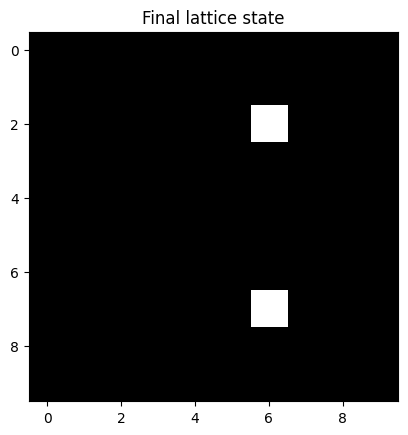

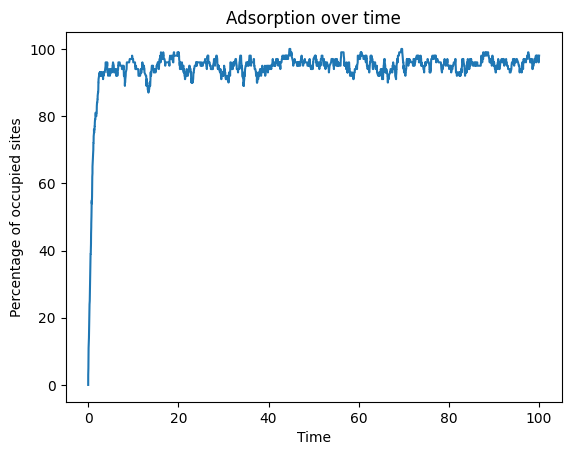

In [7]:
# Plot the final lattice state
plt.imshow(lattice, cmap='binary')
plt.title("Final lattice state")
plt.show()

# Plot percentage of occupied sites over time
occupancy = [np.sum(state == 1) / (lattice_size**2) * 100 for state in states]
plt.plot(times, occupancy)
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()


## **Concepto de Cobertura**

In [8]:
import numpy as np

# Parámetros
lattice_size = (10, 10)  # tamaño de la red
coverage = 0.25  # cobertura de 0.25 ML

# Inicialización de la red vacía
lattice = np.zeros(lattice_size, dtype=int)

# Calcular el número de sitios que deben llenarse
num_sites = lattice_size[0] * lattice_size[1]
num_filled_sites = int(num_sites * coverage)

# Seleccionar aleatoriamente sitios para llenar con átomos de Au
filled_sites = np.random.choice(num_sites, num_filled_sites, replace=False)

# Rellenar los sitios seleccionados con partículas (valor 1)
for site in filled_sites:
    row = site // lattice_size[1]
    col = site % lattice_size[1]
    lattice[row, col] = 1

print("Red inicializada con cobertura de 0.25 ML:")
print(lattice)


Red inicializada con cobertura de 0.25 ML:
[[0 0 1 0 1 1 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0 0 1]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 1 1 0 0 1]
 [0 1 0 0 0 0 0 1 1 1]]


La Superficie de Energía Potencial (PES, por sus siglas en inglés) es una representación multidimensional que describe cómo la energía total de un sistema varía en función de las posiciones de sus átomos o partículas. En términos simples, la PES mapea las configuraciones del sistema (las posiciones de las partículas) con sus energías asociadas. Los puntos clave son:

* Mínimos locales: Representan configuraciones estables o metaestables del sistema.
* Silla de montura (saddle points): Representan los estados de transición entre dos mínimos. La energía en este punto define la barrera de activación para la transición entre los estados.
* Regiones altas de energía: Son configuraciones inestables que el sistema tiende a evitar.

En un modelo KMC, los estados se definen como mínimos locales en la PES, y las transiciones entre estos estados requieren superar las barreras de energía, determinadas por los puntos de silla de montura.

**Dependencia de la configuración del sistema**

**Adsorción dependiente de sitios vecinos**

La energía de adsorción puede depender del número de vecinos ya ocupados (efectos cooperativos o de bloqueo). Por ejemplo, la adsorción puede ser más favorable si un sitio está rodeado por otros iones debido a interacciones atractivas:

$$
k_{\text{ads}} = A \exp\left(-\frac{\Delta E_{\text{ads}} + \Delta E_{\text{int}}}{R T}\right)
$$

Donde $\Delta E_{\text{int}}$ representa la energía adicional debido a vecinos.

**Desorción dependiente de la ocupación**

En sistemas con interacciones fuertes entre adsorbatos, la desorción de un ion puede ser menos probable si está rodeado por otros iones, lo que resulta en una barrera de activación más alta.

**Difusión dependiente de la topología local**

Las tasas de difusión pueden depender del estado de los sitios vecinos. Por ejemplo, un ion puede difundir más fácilmente si el sitio destino está vacío y no hay fuertes interacciones que lo retengan en su posición actual:

$$
k_{\text{diff}} = A \exp\left(-\frac{\Delta E_{\text{diff}}}{R T}\right)
$$


In [9]:
import numpy as np

# Parámetros básicos
A = 1e9  # Factor preexponencial
R = 8.314  # Constante de los gases
T = 298  # Temperatura
E_ads_base = -50e3  # Energía base de adsorción (J/mol)
E_diff_base = 25e3  # Energía base de difusión (J/mol)
interaction_energy = -5e3  # Energía de interacción por vecino ocupado (J/mol)

# Función para calcular energía total de adsorción considerando vecinos
def calculate_adsorption_energy(neighbors):
    return E_ads_base + neighbors * interaction_energy

# Función para calcular tasas
def calculate_rate(energy):
    return A * np.exp(-energy / (R * T))

# Red 3x3 inicial (todos vacíos)
L = np.zeros((3, 3))

# Cálculo de tasas para cada sitio
for i in range(3):
    for j in range(3):
        # Contar vecinos ocupados
        neighbors = 0
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < 3 and 0 <= nj < 3:
                neighbors += L[ni, nj]

        # Calcular energía de adsorción
        E_ads = calculate_adsorption_energy(neighbors)
        k_ads = calculate_rate(E_ads)

        # Imprimir tasa calculada
        print(f"Sitio ({i},{j}) - Vecinos ocupados: {neighbors}, k_ads: {k_ads:.2e}")


Sitio (0,0) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (0,1) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (0,2) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (1,0) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (1,1) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (1,2) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (2,0) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (2,1) - Vecinos ocupados: 0.0, k_ads: 5.81e+17
Sitio (2,2) - Vecinos ocupados: 0.0, k_ads: 5.81e+17


Es necesario a este punto, definir un hamiltoniano del sistema que me permita definir la fuente de energía del sistema y por tanto, las tasas de transición a partir de la ecuación de Eyring.

Consideraciones y restricciones:

* Definir una energía de adsorsión inicial característica del material
* Definir un pocentaje de covertura
* Definir una energía de adsorsión debida a los vecinos. Esta debe cumplir que conforme más vecinos menos la probabilidad de adsorsión. Por ende esta energía debe ser positiva en el exponente.
* En un primer acercamiento se pueden considerar interacciones locales (Sin embargo de puede evaluar la posibilidad de considerar interacciones de largo alcance)
* Tener en cuenta la interacción entre adsorbatos vecinos
* Debe existir un término en la exponencial que hable de la afinidad por adsorsión: Este término favorece o penaliza la adsorción en función del potencial químico, que puede depender de factores como la temperatura, la presión o la concentración de adsorbato en el entorno.

## **Considerando solo adsorsión**

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lattice_size = 10  # 10x10 grid of adsorption sites
E_ads = 0.6       # adsorption rate
E_des = 0.3
E_diff =0.1
e_int = 1.2        # Interaction energy
coverage = 0.8     # coverage percentage
T = 300
k_b = 8.617e-5
h = 6.626e-34


# Number of sites for fill
num_sites = lattice_size**2
num_filled_sites = int(num_sites * coverage)

# Initialize lattice (0 = vacant, 1 = occupied)
lattice = np.zeros((lattice_size, lattice_size))
time = 0.0
times = [time]
states = [lattice.copy()]
lattice

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
def pick_random_site(lattice):
    i,j = np.random.randint(0, 10, size=2)
    site = i,j
    return site

def count_occupied_neighbors(lattice, site):
    neighbors = 0
    i, j = site
    for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
      if 0 <= ni < len(lattice) and 0 <= nj < len(lattice):
        neighbors += lattice[ni, nj]
    return neighbors

def hamiltonian(e_int,site):
  n_ij = count_occupied_neighbors(lattice, site)
  H = e_int * n_ij + E_ads
  return H

def calculate_transition_rates(lattice, site):
    H = hamiltonian(e_int, site)
    k_ads = (k_b*T)/h * np.exp(-H /(k_b*T))
    k_des = (k_b*T)/h * np.exp(-E_des/(k_b*T))
    k_diff = (k_b*T)/h * np.exp(-E_diff/(k_b*T))
    k_total = k_ads + k_des + k_diff
    return k_ads, k_des, k_diff, k_total

def select_event(k_ads,k_des,k_diff):
    # Select which event occurs
    total_propensity = k_ads + k_des + k_diff
    r = np.random.rand() * total_propensity
    if r < k_ads:
        return "adsorption"
    elif r < k_ads + k_des:
        return "desorption"
    else:
        return "diffusion"


In [12]:
num_occupied_sites = 0
end_time = 10


#and num_occupied_sites < num_filled_sites
while time < end_time :

    site = pick_random_site(lattice)

    # Calculate propensities and total propensity
    k_ads, k_des, k_diff, k_total = calculate_transition_rates(lattice, site)
    # print(k_ads, k_des, k_diff, k_total)

    if k_total == 0:
        break  # No more events possible

    # Determine the time to the next event
    delta_t = -np.log(np.random.rand()) / k_total * 1e27
    time += delta_t
    print(time)


    # Select the event type
    event_type = select_event(k_ads, k_des, k_diff)

    print(event_type)

    # Here, we must consider the coverage percentage
    if event_type == "adsorption":
        lattice[site] = 1

    elif event_type == "desorption":
        lattice[site] = 0

    elif event_type == "diffusion" :

        neighbors = [(site[0] + dx, site[1] + dy)
                     for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                     if 0 <= site[0] + dx < lattice_size and 0 <= site[1] + dy < lattice_size]
        vacant_neighbors = [s for s in neighbors if lattice[s] == 0]
        if vacant_neighbors:
            new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
            lattice[site], lattice[new_site] = 0, 1  # Move particle to new site


    num_occupied_sites = int(np.sum(lattice==1))
    times.append(time)
    states.append(lattice.copy())


Streaming output truncated to the last 5000 lines.
6.981047995005531
diffusion
6.981980338981805
diffusion
6.982082609871404
diffusion
6.9826792516753455
diffusion
6.984736954710721
diffusion
6.985843351005612
diffusion
6.987124710632112
diffusion
6.991000035272873
diffusion
6.991159425789929
diffusion
6.994574792238876
diffusion
6.995122445234023
diffusion
6.995175305453923
diffusion
6.995515190560443
diffusion
6.995549328810513
diffusion
6.995558032602522
diffusion
6.995704444995674
diffusion
6.997074990248402
diffusion
6.998006032085681
diffusion
6.998599426399812
diffusion
6.9986705370612405
diffusion
7.000900712393987
diffusion
7.002528078154801
diffusion
7.002918640064361
diffusion
7.005331468140516
diffusion
7.010951313465435
diffusion
7.013541323294582
diffusion
7.014725689880963
diffusion
7.0160148857521305
diffusion
7.017479513044773
diffusion
7.018716168761713
diffusion
7.021159156548301
diffusion
7.021159400017928
diffusion
7.02171477587295
diffusion
7.021800701089399
diffu

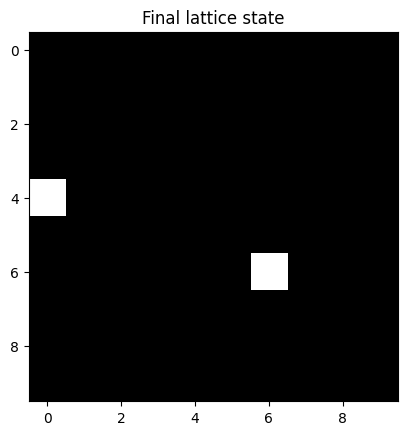

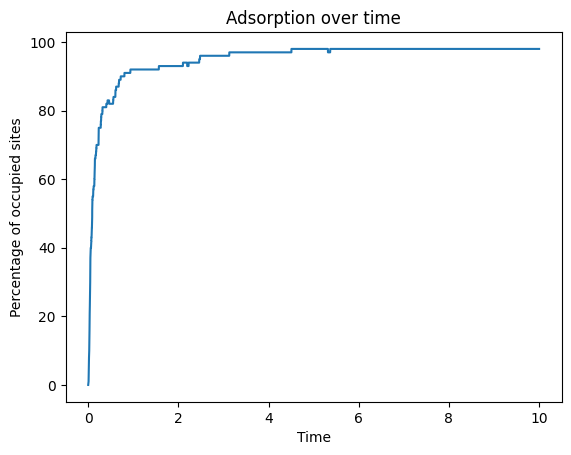

In [13]:
# Plot the final lattice state
plt.imshow(lattice, cmap='binary')
plt.title("Final lattice state")
plt.show()

# Plot percentage of occupied sites over time
occupancy = [np.sum(state == 1) / (lattice_size**2) * 100 for state in states]
plt.plot(np.array(times), occupancy)
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()


Este código tiene un problema en cuanto a los valores y la forma como se calculan las tasas de transición. Sin embargo da una buena aproximación, por lo que se deja para revisión.

Solo está tomando en cuenta procesos de difusión y parece que está adsorbiendo cuando se debería solo hacer difusión

In [14]:
def pick_random_site(lattice):
    i,j = np.random.randint(0, len(lattice), size=2)
    site = i,j
    return site

def count_occupied_neighbors(lattice, site):
    neighbors = 0
    i, j = site
    for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
      if 0 <= ni < len(lattice) and 0 <= nj < len(lattice):
        neighbors += lattice[ni, nj]
    return neighbors

def hamiltonian(e_int,site):
  n_ij = count_occupied_neighbors(lattice, site)
  H = e_int * n_ij + E_ads
  return H

def calculate_transition_rates(lattice, site):
    H = hamiltonian(e_int, site)
    k_ads = (k_b*T)/h * np.exp(-H /(k_b*T))
    k_des = (k_b*T)/h * np.exp(-E_des/(k_b*T))
    k_diff = (k_b*T)/h * np.exp(-E_diff/(k_b*T))
    k_total = k_ads + k_des + k_diff
    return k_ads, k_des, k_diff, k_total

def select_event(k_ads,k_des,k_diff):
    # Select which event occurs
    total_propensity = k_ads + k_des + k_diff
    r = np.random.rand() * total_propensity
    if r < k_ads:
        return "adsorption"
    elif r < k_ads + k_des:
        return "desorption"
    else:
        return "diffusion"


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lattice_size = 100  # 10x10 grid of adsorption sites
E_ads = 6      # adsorption rate
E_des = 400
E_diff = 1000
e_int = 1000          # Interaction energy
coverage = 0.2     # coverage percentage
T = 300
k_b = 1 #8.617e-5
h = 1 #6.626e-34


# Number of sites for fill
num_sites = lattice_size**2
num_filled_sites = int(num_sites * coverage)

# Initialize lattice (0 = vacant, 1 = occupied)
lattice = np.zeros((lattice_size, lattice_size))
time = 0.0
times = [time]
states = [lattice.copy()]
lattice

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
num_occupied_sites = 0
end_time = 100


while time < end_time :

    site = pick_random_site(lattice)

    # Calculate propensities and total propensity
    k_ads, k_des, k_diff, k_total = calculate_transition_rates(lattice, site)
    print(k_ads, k_des, k_diff, k_total)

    if k_total == 0:
        break  # No more events possible

    # Determine the time to the next event
    delta_t = -np.log(np.random.rand()) / k_total
    time += delta_t
    print(time)


    # Select the event type
    event_type = select_event(k_ads, k_des, k_diff)

    print(event_type)

    # Here, we must consider the coverage percentage
    if event_type == "adsorption" :
        lattice[site] = 1

    elif event_type == "desorption":
        lattice[site] = 0

    elif event_type == "diffusion" :
        if lattice[site] == 1:
          neighbors = [(site[0] + dx, site[1] + dy)
                      for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                      if 0 <= site[0] + dx < lattice_size and 0 <= site[1] + dy < lattice_size]
          vacant_neighbors = [s for s in neighbors if lattice[s] == 0]
          if vacant_neighbors:
              new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
              lattice[site], lattice[new_site] = 0, 1  # Move particle to new site
        else:
          lattice[site] = 0

    num_occupied_sites = int(np.sum(lattice==1))
    times.append(time)
    states.append(lattice.copy())


Streaming output truncated to the last 5000 lines.
87.4595559380929
diffusion
10.490280285159242 79.07914143471803 10.702198004175719 100.27161972405298
87.46571888977218
desorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
87.46809908082531
adsorption
10.490280285159242 79.07914143471803 10.702198004175719 100.27161972405298
87.47767598544684
desorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
87.47863828629015
desorption
10.490280285159242 79.07914143471803 10.702198004175719 100.27161972405298
87.48442121173123
diffusion
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
87.49599082239492
desorption
10.490280285159242 79.07914143471803 10.702198004175719 100.27161972405298
87.50915738908982
desorption
0.013350285276422263 79.07914143471803 10.702198004175719 89.79468972417015
87.50949441338902
desorption
0.3742301891035839 79.07914143471803 10.702198004175719 90.15556962799732
87.51639227363223
d

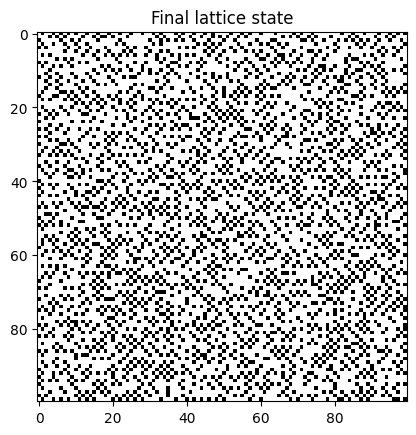

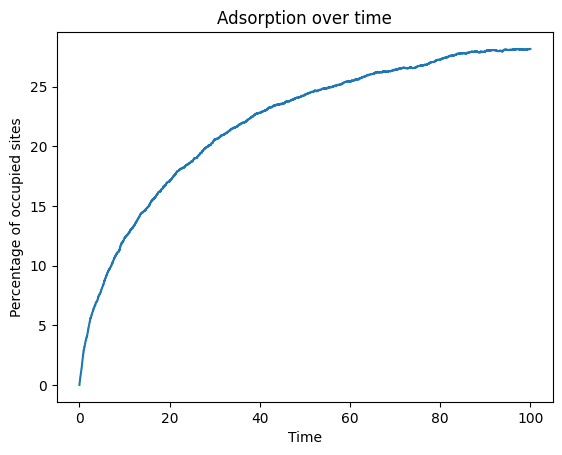

In [30]:
# Plot the final lattice state
plt.imshow(lattice, cmap='binary')
plt.title("Final lattice state")
plt.show()

# Plot percentage of occupied sites over time
occupancy = [np.sum(state == 1) / (lattice_size**2) * 100 for state in states]
plt.plot(np.array(times), occupancy)
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()


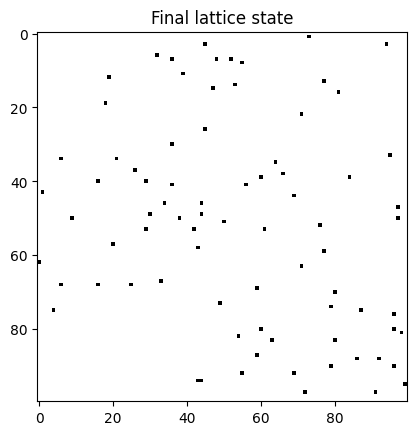

In [31]:
plt.imshow(states[100], cmap='binary')
plt.title("Final lattice state")
plt.show()

In [19]:
np.shape(states[1])

(100, 100)

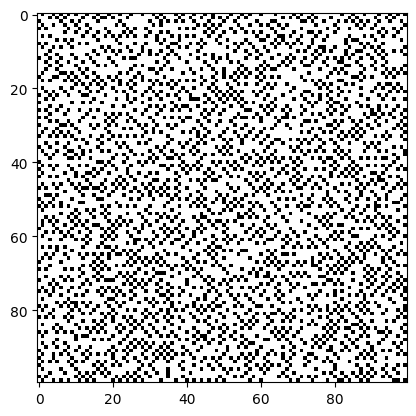

In [34]:
# prompt: con la variabal states que tiene dimensiones 10, 100, 100, realizar una animacion sobre los 10 primeros valores , no puedo ver la simulacion en el collab puedes generar un fit tambien

import matplotlib.animation as animation
from IPython.display import HTML

# Assuming 'states' is your 4D numpy array (10, 100, 100)
# and you want to animate the first 10 time steps

fig, ax = plt.subplots()

ims = []
for i in range(0,len(states),100):
    im = ax.imshow(states[i], cmap='binary') # Use imshow for 2D arrays
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# Display the animation in Colab
HTML(ani.to_jshtml())

# Optionally save the animation to a file:
ani.save('kMC_animation.mp4', writer='ffmpeg', fps=30) #Requires ffmpeg installation

NameError: name 'sampled_states' is not defined

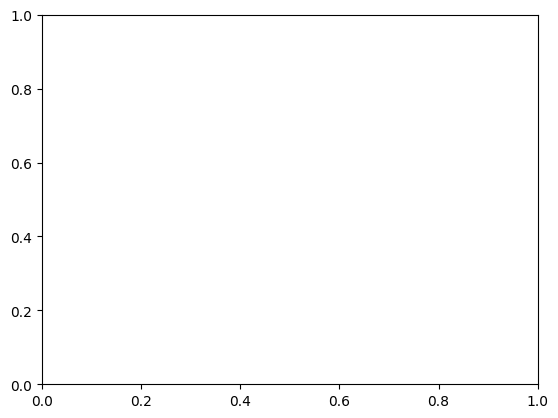

In [21]:
# prompt: Quiero que crees una animación de los sampled_states

import matplotlib.animation as animation

# Assuming 'sampled_states' is already defined from the previous code

fig, ax = plt.subplots()
ims = []

for i in range(len(sampled_states)):
    im = ax.imshow(sampled_states[i], cmap='binary', animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

steps = len(sampled_states)

# Crear figura y eje
fig, ax = plt.subplots()
im = ax.imshow(sampled_states[0], cmap="binary", interpolation="nearest")

# Configuración del título
title = ax.set_title("Evolución del Modelo Ising")

# Función de actualización para la animación
def update(frame):
    im.set_array(sampled_states[frame])
    title.set_text(f"Paso: {frame + 1}")
    return [im, title]

# Crear animación
ani = FuncAnimation(fig, update, frames=steps, interval=200, blit=True)

# Mostrar animación en Colab como HTML5
HTML(ani.to_html5_video())


NameError: name 'sampled_states' is not defined

Se notan clusters de partículas

Como una apreciación de los resultados, si aumentamos la energía de interacción entre vecinos cercanos, la probabilidad de adsorsión disminuye conforme se adsorben más partículas. Lo cual puede ser coherente con el coverage del adsorbente